In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import matplotlib.pyplot as plt

DATA_PROCESSED = Path("../data/processed")

X_train_bal = pd.read_parquet(DATA_PROCESSED / "X_train_bal.parquet")
y_train_bal = pd.read_parquet(DATA_PROCESSED / "y_train_bal.parquet")["target"]
X_test = pd.read_parquet(DATA_PROCESSED / "X_test.parquet")
y_test = pd.read_parquet(DATA_PROCESSED / "y_test.parquet")["target"]


c:\Users\daniel.guedj_arondor\Downloads\perso\openclassrooms\Auto_classif_data\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
param_grid_log = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["lbfgs", "liblinear"]
}
grid_log = GridSearchCV(
    LogisticRegression(max_iter=10000, random_state=42),
    param_grid_log,
    scoring="recall",
    cv=5,
    n_jobs=-1
)
grid_log.fit(X_train_bal, y_train_bal)
print("Best params (Logistic):", grid_log.best_params_)


Best params (Logistic): {'C': 0.01, 'solver': 'lbfgs'}


In [4]:
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "class_weight": ["balanced"]
}
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    scoring="recall",
    cv=5,
    n_jobs=-1
)
grid_rf.fit(X_train_bal, y_train_bal)
print("Best params (RandomForest):", grid_rf.best_params_)


Best params (RandomForest): {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}



🔹 Logistique
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       247
           1       0.33      0.70      0.45        47

    accuracy                           0.72       294
   macro avg       0.63      0.72      0.63       294
weighted avg       0.83      0.72      0.76       294



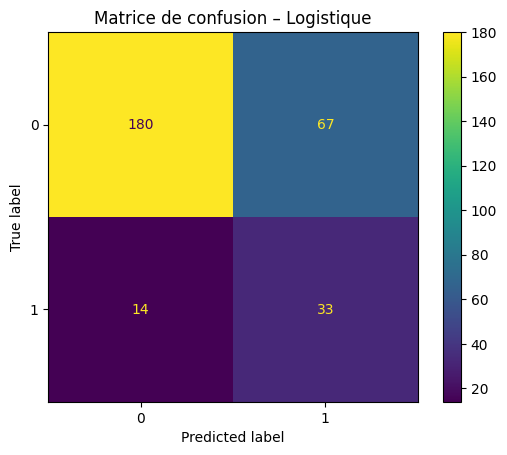


🔹 RandomForest
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       247
           1       0.48      0.21      0.29        47

    accuracy                           0.84       294
   macro avg       0.67      0.58      0.60       294
weighted avg       0.80      0.84      0.81       294



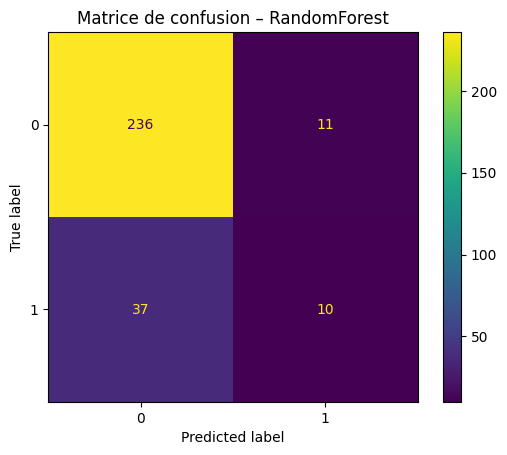

In [5]:
best_log = grid_log.best_estimator_
best_rf = grid_rf.best_estimator_

y_pred_log = best_log.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

for name, y_pred in {"Logistique": y_pred_log, "RandomForest": y_pred_rf}.items():
    print(f"\n🔹 {name}")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title(f"Matrice de confusion – {name}")
    plt.show()


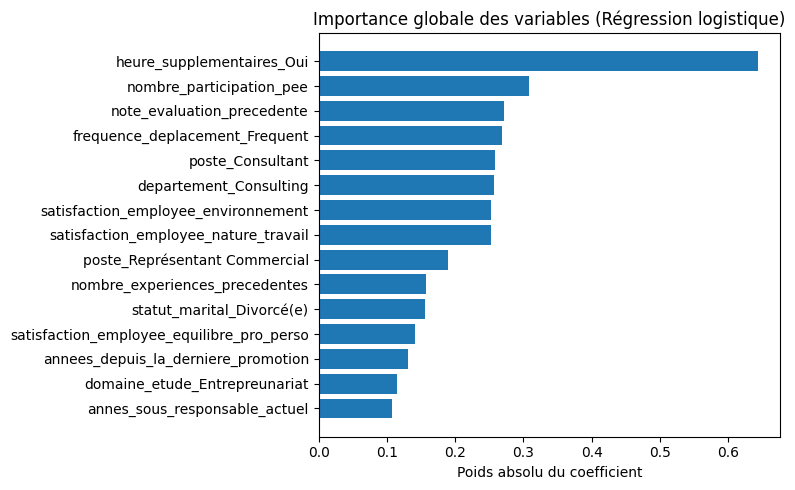

In [6]:
importances = best_log.coef_[0]
features = X_train_bal.columns

idx = np.argsort(abs(importances))[::-1]

plt.figure(figsize=(8,5))
plt.barh(np.array(features)[idx][:15][::-1], abs(importances[idx])[:15][::-1])
plt.title("Importance globale des variables (Régression logistique)")
plt.xlabel("Poids absolu du coefficient")
plt.tight_layout()
plt.show()


👤 Employé 64 → Probabilité de départ : 42.20%



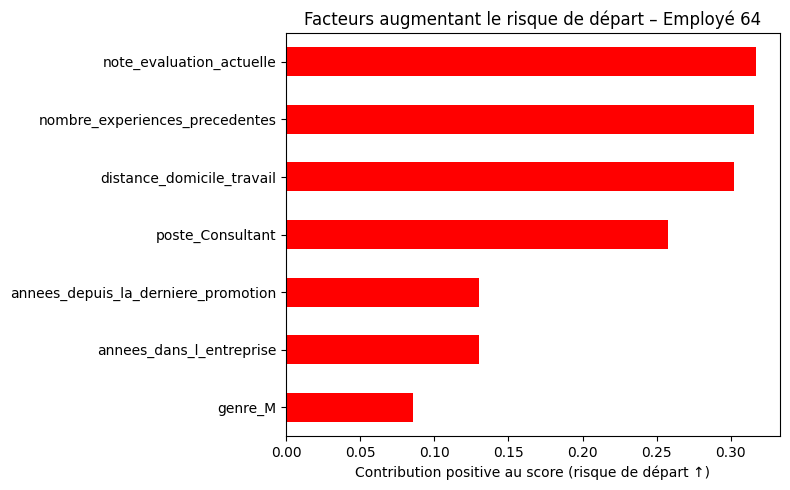


🔝 5 employés les plus susceptibles de partir :


92     92.66%
214    91.41%
200    90.39%
158    89.61%
95     89.54%
dtype: object

In [51]:
idx = 64
x = X_test.loc[idx]

# 2️⃣ Prédiction
proba = best_log.predict_proba(x.to_frame().T)[0][1]

# 3️⃣ Calcul des contributions
contrib = pd.Series(x.values * best_log.coef_[0], index=X_test.columns)

# 4️⃣ Filtrage : uniquement les contributions positives (risque ↑)
contrib_pos = contrib[contrib > 0].sort_values(ascending=True).tail(10)

# 5️⃣ Affichage
print(f"👤 Employé {idx} → Probabilité de départ : {proba*100:.2f}%\n")
plt.figure(figsize=(8,5))
contrib_pos.plot(kind='barh', color='red')
plt.xlabel("Contribution positive au score (risque de départ ↑)")
plt.title(f"Facteurs augmentant le risque de départ – Employé {idx}")
plt.tight_layout()
plt.show()

# 5️⃣ (Optionnel) Top 5 employés les plus susceptibles de partir
probas_all = pd.Series(best_log.predict_proba(X_test)[:,1], index=X_test.index)
top5 = probas_all.sort_values(ascending=False).head(5)
print("\n🔝 5 employés les plus susceptibles de partir :")
display(top5.apply(lambda p: f"{p*100:.2f}%"))
